In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Lab 4

### Incremental averange calculating:

$$Q_{t+1}(a)=Q_t(a)+\frac{1}{c_{t}(a)}\cdot\left(r_{t+1}-Q_t(a)\right)$$

## Generating actions:

In [4]:
class Action:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    def get_reward(self):
        return np.random.normal(self.mu, self.sigma)

In [5]:
rounds_cnt = 1000
actions_cnt = 20
sigma = 1

mus = np.random.normal(0, 1, actions_cnt)
actions = list(map(lambda mu: Action(mu, sigma), mus))

print("Actions rewards expectations: ", mus)

Expectations:  [ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
  0.95008842 -0.15135721 -0.10321885  0.4105985   0.14404357  1.45427351
  0.76103773  0.12167502  0.44386323  0.33367433  1.49407907 -0.20515826
  0.3130677  -0.85409574]


In [176]:
optimal_result = mus.max() * rounds_cnt
print(optimal_result)

2240.8931992


## Graph of average final reward depending on params:

In [227]:
def show_results(params, results, xlabel):
    plt.plot(params, results)
    plt.ylabel('reward expectation', fontsize=13)
    plt.ylim(0, optimal_result)
    plt.xlabel(xlabel, fontsize=30)
    plt.show()

## Graph of average reward on step t:

In [239]:
def show_average_game(history):
    print('Averange final reward: ', history.max())
    plt.plot(history)
    plt.ylabel('average reward', fontsize=13)
    plt.xlabel('t')
    plt.ylim(0, optimal_result)
    plt.show()

## Greedy strategy

In [7]:
class GreedyStrategy:
    def __init__(self, initial_q=0):
        self.initial_q = initial_q
        self.q = np.ones(actions_cnt) * initial_q
        self.cnt = np.zeros(actions_cnt)
        
    def reset(self):
        self.q = np.ones(actions_cnt) * self.initial_q
        self.cnt = np.zeros(actions_cnt)
    
    def choose_action(self):
        best_actions = np.flatnonzero(self.q == self.q.max())
        return np.random.choice(best_actions)
    
    def run(self, actions):
        history = []
        full_reward = 0
        self.t = 0
        while self.t < rounds_cnt:
            action = self.choose_action()
            reward = actions[action].get_reward()
            self.cnt[action] += 1
            self.q[action] += (reward - self.q[action]) / self.cnt[action]
            full_reward += reward
            history.append(full_reward)
            self.t += 1
        return np.array(history)

In [179]:
def average_history(strategy, games=100, progress_range=[0, 100]):
    history = np.zeros(rounds_cnt)
    diff = progress_range[1] - progress_range[0]
    for i in range(games):
        progress = round(progress_range[0] + diff * i / games, 1)
        print('\r' * 10 + str(progress) + '%', end='')
        history += strategy.run(actions) / games
        strategy.reset()
    print('\r' * 10, end='')
    return history

Averange final reward:  2037.70694926


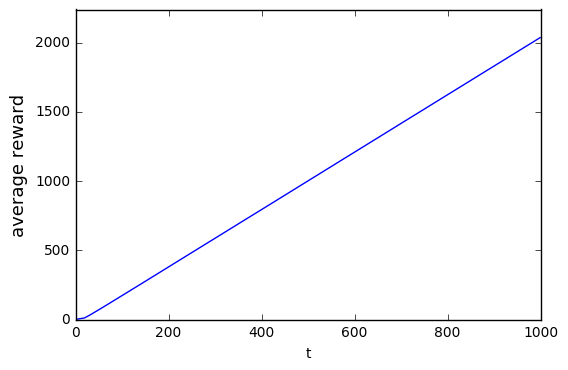

In [235]:
strategy = GreedyStrategy(initial_q=5)
greedy_history = average_history(strategy, games=1000)

show_average_game(greedy_history)

Изначально $\forall a\ Q(a)=5$. Значение подобрано так, чтобы жадный алгоритм почти наверняка изучил все действия, прежде чем выбрать наилучшее.

Главный недостаток алгоритма - зависимость от начальных параметров.

Если о распределениях ничего неизвестно, придется сыграть несколько игр, чтобы найти достаточно большое начальное значение.

# $\varepsilon$-Greedy strategy

In [9]:
class EGreedyStrategy(GreedyStrategy):
    def __init__(self, initial_q=0, epsilon=0):
        self.initial_q = initial_q
        self.epsilon = epsilon
        self.q = np.ones(actions_cnt) * initial_q
        self.cnt = np.zeros(actions_cnt)
    
    def choose_action(self):
        best_actions = np.flatnonzero(self.q == self.q.max())
        gr_choice = np.random.choice(best_actions)
        exp_choice = np.random.randint(actions_cnt)
        probabilities = [1 - self.epsilon, self.epsilon]
        return np.random.choice([gr_choice, exp_choice], p=probabilities)

Здесь $Q(a)$ инициализируется нулями, так как если подбирать большие значения, как в предыдущей стратегии, то $\varepsilon$-стратегия теряет смысл.

## Optimizing $\varepsilon$

In [180]:
def evaluate_params(Strategy, params, games=100):
    strategies = list(map(Strategy, params))
    results = []
    i = 0
    for st in strategies:
        results.append(average_history(st, games=games, progress_range=[1.0 * i / len(strategies) * 100, 1.0 * (i + 1) / len(strategies) * 100]).max())
        i += 1
    return results

Optimal epsilon:  0.0657894736842


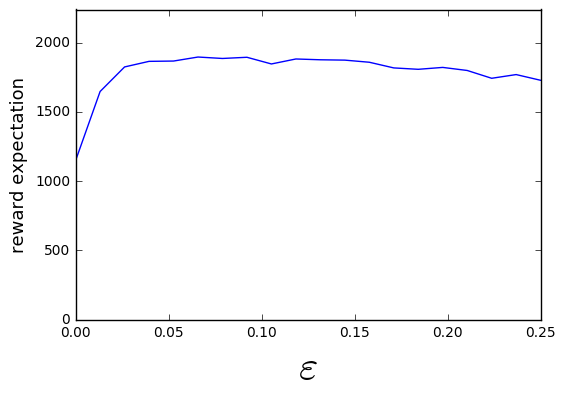

In [178]:
def Strategy(epsilon):
    return EGreedyStrategy(epsilon=epsilon)

epsilons = np.linspace(0.0, 0.25, num=20)
results = evaluate_params(Strategy, epsilons, games=100)

egreedy_epsilon_opt = epsilons[np.argmax(results)]
print("Optimal epsilon: ", egreedy_epsilon_opt)

show_results(epsilons, results, r'$varepsilon')

Averange final reward:  1924.83465069


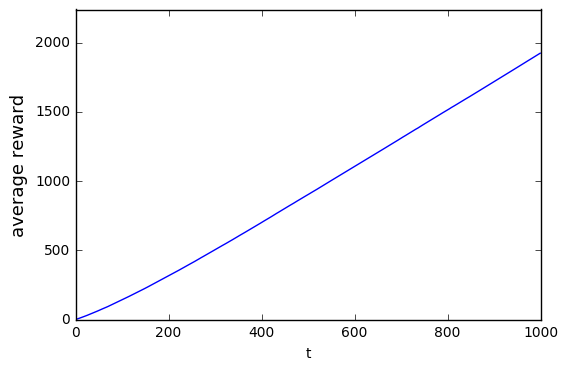

In [240]:
st = EGreedyStrategy(epsilon=egreedy_epsilon_opt)
egreedy_history = average_history(st, games=100)

show_average_game(egreedy_history)

# Softmax Strategy

При $\varepsilon\to 0$ стратегия превращается в обычную жадную, при $\varepsilon\to\infty$ действие выбирается случайно.

In [14]:
def softmax(x):
    e_x = np.exp(x - x.max())
    return e_x / e_x.sum()

In [15]:
class SoftmaxStrategy(EGreedyStrategy):    
    def choose_action(self):
        return np.random.choice(np.arange(actions_cnt), p=softmax(self.q / self.epsilon))

Optimal epsilon:  0.314137931034


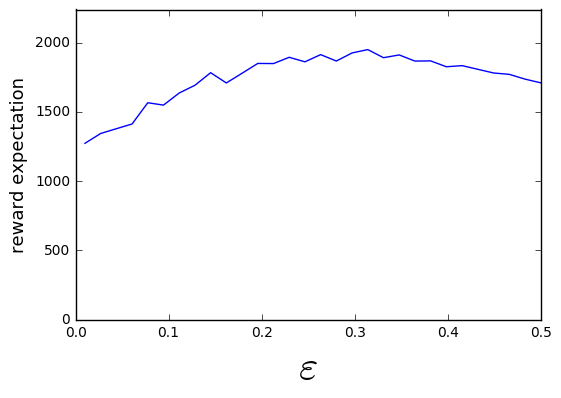

In [183]:
def Strategy(epsilon):
    return SoftmaxStrategy(epsilon=epsilon)

epsilons = np.linspace(0.01, 0.5, num=30)
results = evaluate_params(Strategy, epsilons, games=100)

softmax_epsilon_opt = epsilons[np.argmax(results)]
print("Optimal epsilon: ", softmax_epsilon_opt)

show_results(epsilons, results, r'$varepsilon$')

Averange final reward:  1895.41059104


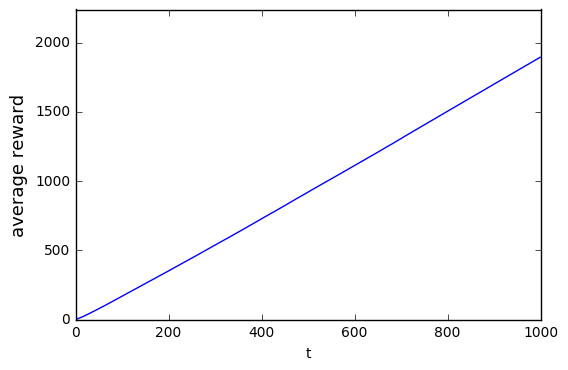

In [241]:
st = SoftmaxStrategy(epsilon=softmax_epsilon_opt)
softmax_history = average_history(st, games=100)

show_average_game(softmax_history)

# Upper confidence bound

In [191]:
class UCBStrategy(EGreedyStrategy):        
    def choose_action(self):
        if self.t < actions_cnt:
            unplayed_actions = np.flatnonzero(self.cnt == 0)
            return np.random.choice(unplayed_actions)
        potential = self.q + self.epsilon * np.sqrt(2 * np.log(self.t) / self.cnt)
        best_actions = np.flatnonzero(potential == potential.max())
        return np.random.choice(best_actions)

Optimal epsilon:  0.538461538462


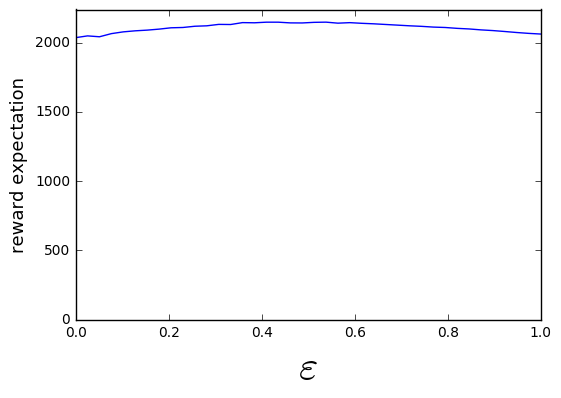

In [242]:
def Strategy(epsilon):
    return UCBStrategy(epsilon=epsilon)

epsilons = np.linspace(0.0, 1.0, num=40)
results = evaluate_params(Strategy, epsilons, games=1000)

ucb_epsilon_opt = epsilons[np.argmax(results)]
print("Optimal epsilon: ", ucb_epsilon_opt)

show_results(epsilons, results, r'$\varepsilon$')

Averange final reward:  2146.93132918


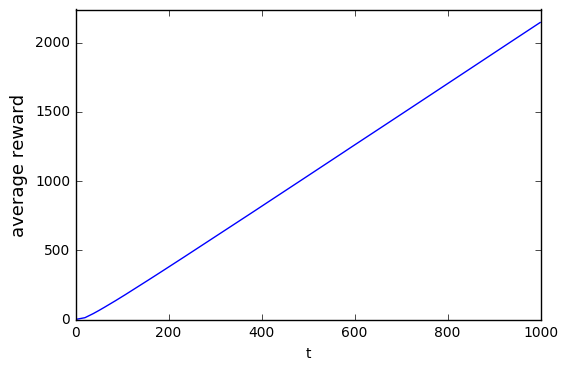

In [245]:
st = UCBStrategy(epsilon=ucb_epsilon_opt)
ucb_history = average_history(st, games=1000)

show_average_game(ucb_history)

# Gradient bandit policy

In [195]:
class GradientBanditStrategy:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        self.average_reward = 0
        self.h = np.zeros(actions_cnt)
        self.pr = softmax(self.h)
        
    def reset(self):
        self.h = np.zeros(actions_cnt)
        self.average_reward = 0
        self.pr = softmax(self.h)
        
    def choose_action(self):
        return np.random.choice(np.arange(actions_cnt), p=self.pr)
    
    def update(self, chosen_action, reward):
        self.average_reward += self.alpha(self.t) * (reward - self.average_reward)
        for i in range(actions_cnt):
            if i == chosen_action:
                self.h[i] += self.beta * (reward - self.average_reward) * (1 - self.pr[i])
            else:
                self.h[i] -= self.beta * (reward - self.average_reward) * self.pr[i]
        self.pr = softmax(self.h)
        
    def run(self, actions):
        history = []
        full_reward = 0
        self.t = 0
        while self.t < rounds_cnt:
            action = self.choose_action()
            reward = actions[action].get_reward()
            self.update(action, reward)
            full_reward += reward
            history.append(full_reward)
            self.t += 1
        return np.array(history)
        

In [196]:
def alpha(t):
    return 1 / (t + 1)

st = GradientBanditStrategy(alpha, 0.1)

In [ ]:
def Strategy(beta):
    return GradientBanditStrategy(alpha=alpha, beta=beta)

betas = np.linspace(0.0, 2.0, num=40)
results = evaluate_params(Strategy, betas, games=1000)

grad_beta_opt = epsilons[np.argmax(results)]
print("Optimal beta: ", grad_beta_opt)

show_results(betas, results, r'$\beta$')

26.4%

Averange final reward:  1913.58946149


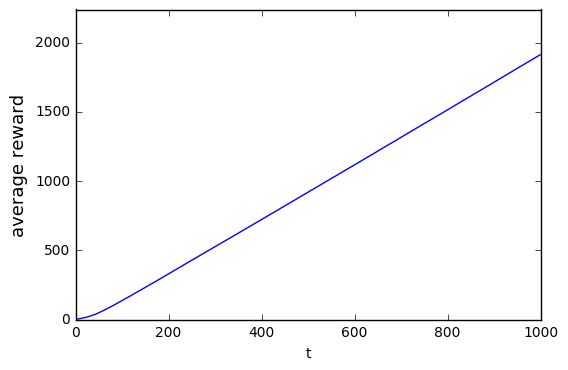

In [251]:
st = GradientBanditStrategy(alpha, grad_beta_opt)
grad_history = average_history(st, games=100)

show_average_game(grad_history)

# Strategies comparison

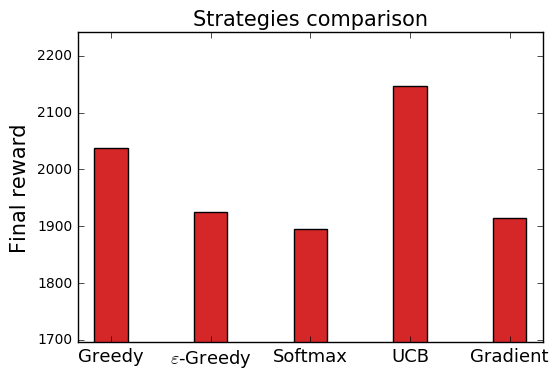

In [255]:
histories = [greedy_history, egreedy_history, softmax_history, ucb_history, grad_history]
results = np.array(list(map(np.max, histories)))
positions_x = np.arange(len(histories)) * 3
width = 1
p1 = plt.bar(positions_x + 0.5, results, width, color='#d62728')

plt.ylabel('Final reward', fontsize=15)
plt.ylim(results.min()-200, optimal_result)
plt.title('Strategies comparison', fontsize=15)
plt.xticks(positions_x + 1, ('Greedy', r'$\varepsilon$-Greedy', 'Softmax', 'UCB', 'Gradient'), fontsize=13)
plt.show()

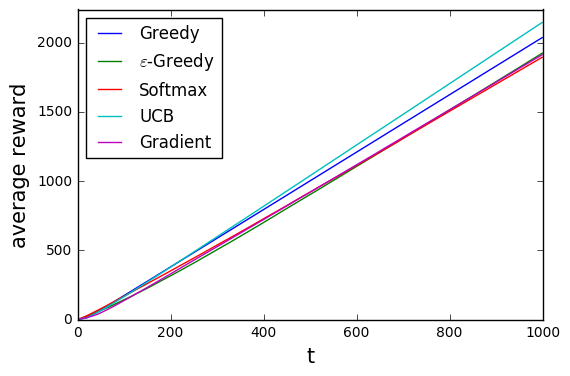

In [254]:
plt.plot(greedy_history, label='Greedy')
plt.plot(egreedy_history, label=r'$\varepsilon$-Greedy')
plt.plot(softmax_history, label='Softmax')
plt.plot(ucb_history, label='UCB')
plt.plot(grad_history, label='Gradient')
plt.xlabel('t', fontsize=15)
plt.ylabel('average reward', fontsize=15)
plt.ylim(0, optimal_result)
plt.legend(loc=2)
plt.show()